#X-Ray Scattering Data

In [1]:
%matplotlib inline

import json as json
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse

# from statsmodels

#Load Data

Load data from file into a list of numpy arrays. The regressions are in `X` and the predictors are in `y`.

In [2]:
def make_array(file_path, ar_order):
    data_dicts = _dicts_from_json(file_path)
    keys = data_dicts[0].keys()
    sample_numbers, sample_lists = _create_sample_lists(keys, data_dicts)
    array_length, sample_index = _array_length_index(sample_numbers,
                                                     sample_lists[0])
    X, y = _make_array(array_length, sample_index, sample_lists)
    return _add_ar_terms(X, y, ar_order, len(sample_numbers))


def _create_sample_lists(keys, data_dicts):
    sample_name = []
    strains = []
    pc_points = []
    stresses = []
    per_crys = []
    for pt_dict in data_dicts:
        sample_name.append(pt_dict[keys[3]])
        strains.append(pt_dict[keys[4]])
        stresses.append(pt_dict[keys[2]])
        per_crys.append(pt_dict[keys[6]])
        pc_points.append(np.array(pt_dict[keys[5]]))
    l = [sample_name, pc_points, strains, stresses, per_crys]
    return sorted(set(sample_name)), l


def _dicts_from_json(file_path):
    with open(file_path) as json_file:
        data_dicts = json.load(json_file)
    return data_dicts


def _array_length_index(sample_numbers, sample_name):
    array_length = []
    for sample in sample_numbers:
        array_length.append(sample_name.count(sample))
    sample_index = np.concatenate((np.array([0]), np.cumsum(array_length) - 1))
    return array_length, sample_index


def _make_array(array_length, sample_index, sample_lists):
    y_ = []
    X_ = []
    for rr in range(len(array_length)):
        index_0, index_1 = sample_index[rr] + 10, sample_index[rr + 1]
        X_.append(np.concatenate(
                  (np.array(sample_lists[2][index_0:index_1])[..., None],
                   np.array(
                      sample_lists[3][index_0:index_1])[..., None],
                   np.array(sample_lists[4][index_0:index_1])[..., None]),
                  axis=-1))
        y_.append(np.array(sample_lists[1][index_0:index_1]))
    return X_, y_


def _add_ar_terms(X, y, ar_order, n_samples):
    ar_list = range(ar_order + 1)[1:]
    X_ = []
    sample_numbers = range(n_samples)
    for sample in sample_numbers:
        X_auto = []
        y_tmp = np.zeros(y[sample].shape)
        for ar_term in ar_list:
            y_tmp[:ar_term] = y[sample][0]
            y_tmp[ar_term:] = y[sample][:-ar_term]
            X_auto.append(y_tmp)
        X_.append(np.concatenate((X[sample],
                                  np.concatenate((X_auto)))
                                , axis=-1))
    return X_, y

In [3]:
ar_order = 1
file_path = '/home/david/git/MIC-XRD-Polymer/visualization/Vis_data.json'

X_, y_ = make_array(file_path, ar_order)

#Make Regression model

In [4]:
model = Pipeline([('poly', PolynomialFeatures(2)), ('linear', LinearRegression())])

#Select training dataset and regressors

In [5]:
exogenious = [0] # 0 - Strain, 1 - Stress, 2 - % Crystalline,
n_regressors = exogenious + [3, 4, 5, 6, 7, 8, 9,]# 3-9 - PCs
train_samples = [0, 1, 2, 3, 6, 7, 8, 9]

X = np.concatenate(([X_[sample] for sample in train_samples]))
y = np.concatenate(([y_[sample] for sample in train_samples]))

$$y_t = \beta_1 y_{t-1} + \beta_2 strain + e$$

#Fit model

In [6]:
model.fit(X[:, n_regressors], y)

Pipeline(steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, normalize=False))])

#Check fit

In [7]:
print 'R-squared', model.score(X[:, n_regressors], y)
print 'MSE', mse(y, model.predict(X[:, n_regressors]))
print 'Sum Euclidean Distance Between Points', np.linalg.norm(model.predict(X[:, n_regressors]) - y)

R-squared 0.999816774943
MSE 0.0212289919954
Sum Euclidean Distance Between Points 15.7344369029


#Select Testing Dataset

In [8]:
test_samples = [4]
X_test = np.concatenate(([X_[sample] for sample in test_samples]))
y_test = np.concatenate(([y_[sample] for sample in test_samples]))

#Predict new locations

In [9]:
y_pred_test = model.predict(X_test[:, n_regressors])
print 'R-squared', model.score(X_test[:, n_regressors], y_test)
print 'Sum Euclidean Distance Between Points', np.linalg.norm(y_pred_test - y_test)
print 'MSE', mse(y_pred_test, y_test)

R-squared 0.99963873252
Sum Euclidean Distance Between Points 7.00018759181
MSE 0.02978883059


In [10]:
def _project_predict(X__, y__, ar_order, model, n_regressors, x_terms):
    y__project = np.zeros(y__.shape)
    X__project = X__.copy()
    ar_list = range(ar_order + 1)[1:]
    print X__.shape[0] - ar_order
    for ii in range(X__.shape[0] - ar_order):
        y__project[ii] =  model.predict(X__[ii, n_regressors])
        X__project[ii + 1, n_regressors[x_terms:]] = y__project[ii]
    return X__project, y__project

In [13]:
print X_test.shape
X_project, y_project = _project_predict(X_test, y_test, ar_order, model,
                                        n_regressors, len(exogenious))
print 

 (235, 10)
(1666, 8)
234



In [14]:
print 'R-squared', model.score(X_project[:, n_regressors], y_test)
print 'Sum Euclidean Distance Between Points', np.linalg.norm(y_project - y_test)
print 'MSE', mse(y_project, y_test)

R-squared 0.999048972002
Sum Euclidean Distance Between Points 35.2185326848
MSE 0.754009145575


#Plot Training Results

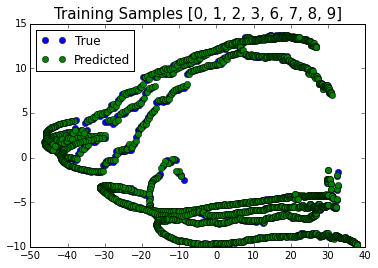

In [15]:
n_components = [0, 2]
y_pred = model.predict(X[:, n_regressors])
plt.plot(y[:, n_components[0]], y[:, n_components[1]], 'bo', label='True')
plt.plot(y_pred[:, n_components[0]], y_pred[:, n_components[1]], 'go', label='Predicted')
plt.legend(loc=2)
plt.title('Training Samples ' + str(train_samples), fontsize=15)

#Plot Testing Results

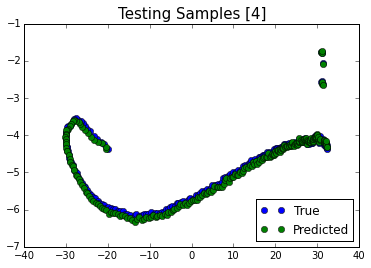

In [16]:
plt.plot(y_test[:, n_components[0]], y_test[:, n_components[1]], 'bo', label='True')
plt.plot(y_pred_test[:, n_components[0]], y_pred_test[:, n_components[1]], 'go', label='Predicted')
plt.legend(loc=4)
plt.title('Testing Samples ' + str(test_samples), fontsize=15)

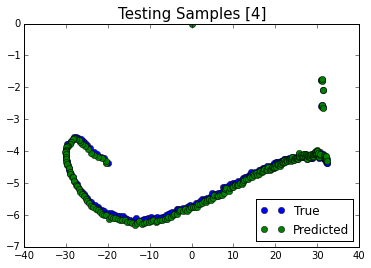

In [17]:
plt.plot(y_test[:, n_components[0]], y_test[:, n_components[1]], 'bo', label='True')
plt.plot(y_project[:, n_components[0]], y_project[:, n_components[1]], 'go', label='Predicted')
plt.legend(loc=4)
plt.title('Testing Samples ' + str(test_samples), fontsize=15)